Initializing dataset with directory: /kaggle/input/images-medical-jpg/image_medical
787 images found in /kaggle/input/images-medical-jpg/image_medical
Epoch 0/350 => Loss_D: 1.0761228437934602 Loss_G: 5.425091402871268
Epoch 1/350 => Loss_D: 0.08826396667531558 Loss_G: 7.3297529220581055
Epoch 2/350 => Loss_D: 0.04614313957946641 Loss_G: 7.7427753039768765
Epoch 3/350 => Loss_D: 0.036422020622662137 Loss_G: 8.708029474530901
Epoch 4/350 => Loss_D: 0.02229429834655353 Loss_G: 8.459403310503278
Epoch 5/350 => Loss_D: 0.01918286830186844 Loss_G: 8.593944277082171
Epoch 6/350 => Loss_D: 0.0172801013769848 Loss_G: 8.547621999468122
Epoch 7/350 => Loss_D: 0.015483933101807321 Loss_G: 8.478486878531319
Epoch 8/350 => Loss_D: 0.013269615492650442 Loss_G: 8.44021647317069
Epoch 9/350 => Loss_D: 0.012217087005930287 Loss_G: 8.290235791887556
Epoch 10/350 => Loss_D: 0.014876286499202251 Loss_G: 8.825518199375697
Epoch 11/350 => Loss_D: 2.27092174630213 Loss_G: 17.55462053843907
Epoch 12/350 => Lo

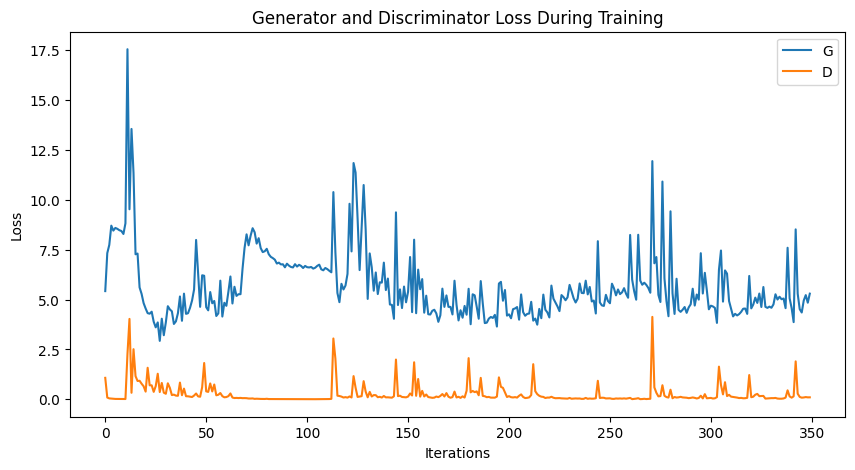

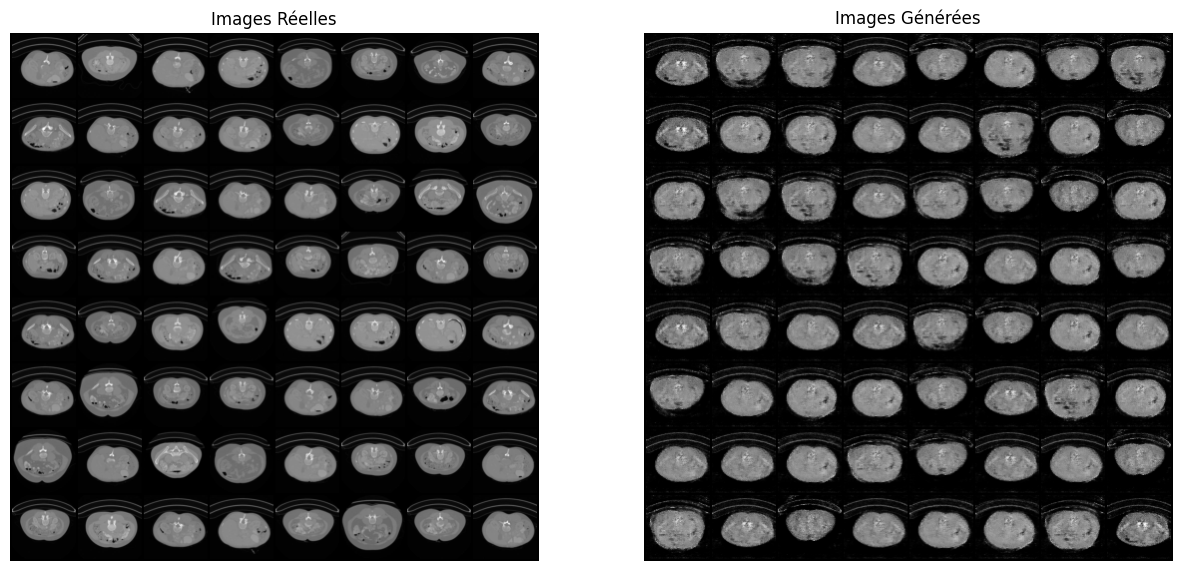

In [6]:
import torch

import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import os
from torch.utils.data import DataLoader
from PIL import Image
from torch.utils.data import Dataset
import numpy as np
import matplotlib.pyplot as plt
import torchvision.utils as vutils
from IPython.display import HTML

import shutil  # Import shutil for zipping
import matplotlib.animation as animation
# Custom dataset class for medical grayscale images
class MedicalImagesDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        print(f"Initializing dataset with directory: {root_dir}")
        self.root_dir = root_dir
        self.transform = transform
        
        # List all the .jpg images in the directory
        self.image_paths = [
            os.path.join(root_dir, fname) 
            for fname in os.listdir(root_dir) 
            if fname.lower().endswith('.jpg')
        ]
        
        print(f"{len(self.image_paths)} images found in {root_dir}")
        if len(self.image_paths) == 0:
            print("No files found, check your path!")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        #print(f"Loading image: {img_path}")
        
        img = Image.open(img_path).convert('L')  # Convert to grayscale ('L' for grayscale)
        
        if self.transform:
            img = self.transform(img)
        
        return img

# Training parameters
dataroot ="/kaggle/input/images-medical-jpg/image_medical"  # Directory containing medical images
batch_size = 128
image_size = 64
nc = 1  # Number of channels (1 for grayscale)
nz = 100  # Length of the latent vector
ngf = 64  # Depth of feature maps in the generator
ndf = 64  # Depth of feature maps in the discriminator
num_epochs = 350
lr = 0.0002
beta1 = 0.5

# Image transformations for training
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),  # Normalize the image for one channel (grayscale)
])

# Create dataset and dataloader
dataset = MedicalImagesDataset(root_dir=dataroot, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Weight initialization function (as in the DCGAN paper)
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# DCGAN Generator model for grayscale images
class Generator(nn.Module):
    def __init__(self, ngf, nz, nc):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh(),
        )

    def forward(self, input):
        return self.main(input)

# DCGAN Discriminator model for grayscale images
class Discriminator(nn.Module):
    def __init__(self, ndf, nc):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid(),
        )

    def forward(self, input):
        return self.main(input)

# Choose the device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate models
netG = Generator(ngf, nz, nc).to(device)
netD = Discriminator(ndf, nc).to(device)

# Initialize weights
netG.apply(weights_init)
netD.apply(weights_init)

# Loss function and optimizers
criterion = nn.BCELoss()

optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))
img_list = []
G_losses = []
D_losses = []

# Train the DCGAN model
for epoch in range(num_epochs):
    # Initialize variables for losses for each epoch
    running_loss_D = 0.0
    running_loss_G = 0.0

    for i, data in enumerate(dataloader, 0):
        # Update the discriminator with real and fake images
        netD.zero_grad()
        real_images = data.to(device)
        b_size = real_images.size(0)
        label = torch.full((b_size,), 1, device=device).float()  # Convert to Float

        output = netD(real_images)
        errD_real = criterion(output.view(-1), label)
        errD_real.backward()

        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake_images = netG(noise)
        label.fill_(0).float()  # Convert to Float

        output = netD(fake_images.detach())
        errD_fake = criterion(output.view(-1), label)
        errD_fake.backward()
        errD = errD_real + errD_fake
        optimizerD.step()

        # Update the generator
        netG.zero_grad()
        label.fill_(1).float()  # Convert to Float
        output = netD(fake_images)
        errG = criterion(output.view(-1), label)
        errG.backward()
        optimizerG.step()

        # Accumulate the losses
        running_loss_D += errD.item()
        running_loss_G += errG.item()

    # Print the average losses for the epoch
    print(f"Epoch {epoch}/{num_epochs} => Loss_D: {running_loss_D/len(dataloader)} Loss_G: {running_loss_G/len(dataloader)}")
    G_losses.append(running_loss_G / len(dataloader))
    D_losses.append(running_loss_D / len(dataloader))

    # Save and visualize generated images after each epoch
if epoch % 1 == 0:
    vutils.save_image(fake_images.detach(), f"output_epoch_{epoch}.png", normalize=True)
    with torch.no_grad():
        fake = netG(torch.randn(64, nz, 1, 1, device=device)).detach().cpu()
        img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

# 1. Courbes de pertes
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses, label="G")
plt.plot(D_losses, label="D")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()
# Plot Real vs Fake Medical Images
# Grab a batch of real images from the dataloader (assuming grayscale images are loaded)
# Nombre d'images à afficher
num_images = 64
# Récupérer une grille d'images générées de la dernière époque
fake_images = img_list[-1]  # Image en format (C, H, W)

# side by side 
plt.figure(figsize=(15,8))
# real 
plt.subplot(1, 2, 1)
plt.axis("off")
plt.title("Images Réelles")
plt.imshow(np.transpose(vutils.make_grid(real_batch[:num_images], padding=2, normalize=True).cpu(), (1, 2, 0)), cmap='gray')

#fake
plt.subplot(1, 2, 2)
plt.axis("off")
plt.title("Images Générées")
plt.imshow(np.transpose(fake_images, (1,2,0)), cmap='gray')

plt.show()

In [ ]:

import torch

import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import os
from torch.utils.data import DataLoader
from PIL import Image
from torch.utils.data import Dataset
import numpy as np
import matplotlib.pyplot as plt
import torchvision.utils as vutils
from IPython.display import HTML

import shutil  # Import shutil for zipping
import matplotlib.animation as animation

fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

In [ ]:
import shutil
output_root = '/kaggle/working/'
shutil.make_archive(f"{output_root}images_generated", 'zip', output_root)

In [ ]:
#  Epoch 49/50 => Loss_D: 0.06447744103414672 Loss_G: 5.318968227931431
# Epoch 99/100 => Loss_D: 0.11371721007994243 Loss_G: 4.984694276537214
#Epoch 149/150 => Loss_D: 0.32426102246556965 Loss_G: 4.26883772441319
#Epoch 249/250 => Loss_D: 0.03673938049801758 Loss_G: 4.9730095863342285
#Epoch 199/200 => Loss_D: 0.032346553834421296 Loss_G: 5.241856234414237